In [1]:
#Import libraries
import pandas as pd
from xml.dom import minidom
import os
import sys
import numpy as np
import matplotlib
import random
import shutil

%matplotlib inline

In [2]:
#Set stile per plotting
#matplotlib.style.available per lista stili
matplotlib.style.use('seaborn')

In [3]:
#Global variables
ILSVRC_ROOT_PATH = '/var/ifs/data'
ANNOTATIONS_PATH = ILSVRC_ROOT_PATH + '/Annotations/CLS-LOC'
ANNOTATIONS_TRAIN_PATH = ANNOTATIONS_PATH + '/train'
ANNOTATIONS_VAL_PATH = ANNOTATIONS_PATH + '/val'
IMAGES_PATH = ILSVRC_ROOT_PATH + '/Data/CLS-LOC'
IMAGES_TRAIN_PATH = IMAGES_PATH + '/train'
TARGET_DIR = 'SMALL_ILSVRC'
DESIRED_SAMPLES = 10

### Retrieve images_df file

In [4]:
images_df = pd.read_csv('images_df.csv', sep=';', header=0)
images_df.head(10)

,path,label,im_dim
0,/ILSVRC/Data/CLS-LOC/train/n02823750/n02823750...,n02823750,166500
1,/ILSVRC/Data/CLS-LOC/train/n02823750/n02823750...,n02823750,167000
2,/ILSVRC/Data/CLS-LOC/train/n02823750/n02823750...,n02823750,187500
3,/ILSVRC/Data/CLS-LOC/train/n02823750/n02823750...,n02823750,187500
4,/ILSVRC/Data/CLS-LOC/train/n02823750/n02823750...,n02823750,166500
5,/ILSVRC/Data/CLS-LOC/train/n02823750/n02823750...,n02823750,187500
6,/ILSVRC/Data/CLS-LOC/train/n02823750/n02823750...,n02823750,187500
7,/ILSVRC/Data/CLS-LOC/train/n02823750/n02823750...,n02823750,174000
8,/ILSVRC/Data/CLS-LOC/train/n02823750/n02823750...,n02823750,187500
9,/ILSVRC/Data/CLS-LOC/train/n02823750/n02823750...,n02823750,187500


In [5]:
#Group by label for counting how many images for label
label_count_df = images_df[['path','label']].groupby(['label'],as_index=False).agg(['count'])
#Flatten indexes (group by generate nested indexes)
label_count_df = label_count_df.reset_index()
label_count_df.columns = ['label', 'count']
label_count_df = label_count_df.sort(['count'], ascending=False)
label_count_df.head(5)

/opt/continuum/anaconda3/envs/jupyter/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,label,count
242,n02108089,1300
978,n09428293,1268
267,n02113799,1248
827,n04330267,1196
867,n04467665,1192


### Visualizing Distribution

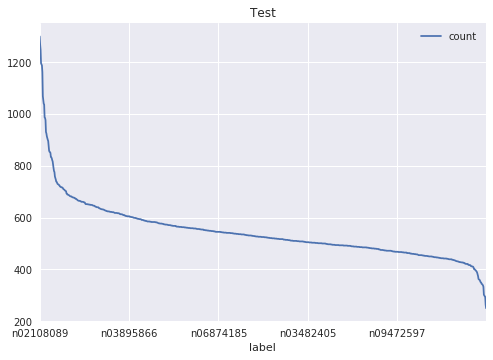

In [6]:
label_count_df.plot(x='label', y='count', title='Test', kind='line')

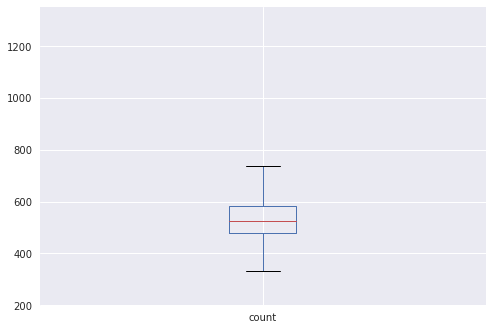

In [7]:
label_count_df.plot.box()

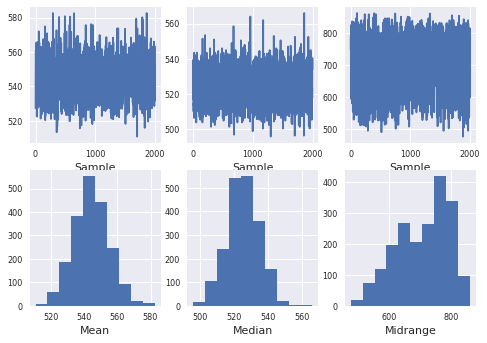

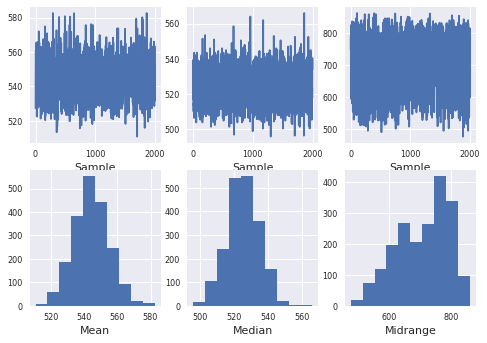

In [8]:
from pandas.tools.plotting import bootstrap_plot
bootstrap_plot(label_count_df['count'], size=100, samples=2000)

In [9]:
count_array = np.array(label_count_df['count'])
count_mean = count_array.mean()
count_std = count_array.std()
count_median = np.median(count_array)
print("Mean: {0}".format(count_mean))
print("STD Dev {0}".format(count_std))
print("Median {0}".format(count_median))

Mean: 544.546
STD Dev 113.15942684549087
Median 525.0


### Extract labels
* Seleziona gruppo di classi che si discostano non più di x dalla media
* Estrazione randomica di n classi
* Creazione archivio di esempio

In [10]:
min_allowed_count, max_allowed_count = count_median - count_std, count_median + count_std

One sigma è un DF che contiene solo i label entro $1 * \sigma$ dalla mediana 
$(\mu - 1* \sigma) <= x <= (\mu + 1 * \sigma)$

In [11]:
one_sigma_count = label_count_df[
    (label_count_df['count'] >= min_allowed_count) & 
    (label_count_df['count'] <= max_allowed_count)
]
one_sigma_count[:10]

,label,count
114,n01945685,638
947,n07734744,636
177,n02092002,636
542,n03250847,635
856,n04428191,634
888,n04532670,633
424,n02791270,633
329,n02321529,632
218,n02102177,632
655,n03770439,632


In [12]:
#Conversione a sigma
one_sigma_list = list(one_sigma_count['label'])

In [13]:
#Extract a random sample of possible indices
extracted_indices= random.sample(range(len(one_sigma_list)), DESIRED_SAMPLES)
extracted_folders = [one_sigma_list[idx] for idx in extracted_indices]
extracted_folders

['n01689811',
 'n01776313',
 'n03063599',
 'n04235860',
 'n07716358',
 'n02086240',
 'n02823428',
 'n03347037',
 'n02096051',
 'n03742115']

In [14]:
#Dataframe che contiene le soli immagini selezionate
to_extract_images = images_df[images_df['label'].isin(extracted_folders)]
len(to_extract_images)
to_extract_images.head(10)

,path,label,im_dim
7003,/ILSVRC/Data/CLS-LOC/train/n01689811/n01689811...,n01689811,187500
7004,/ILSVRC/Data/CLS-LOC/train/n01689811/n01689811...,n01689811,166000
7005,/ILSVRC/Data/CLS-LOC/train/n01689811/n01689811...,n01689811,175000
7006,/ILSVRC/Data/CLS-LOC/train/n01689811/n01689811...,n01689811,179000
7007,/ILSVRC/Data/CLS-LOC/train/n01689811/n01689811...,n01689811,187500
7008,/ILSVRC/Data/CLS-LOC/train/n01689811/n01689811...,n01689811,187500
7009,/ILSVRC/Data/CLS-LOC/train/n01689811/n01689811...,n01689811,230000
7010,/ILSVRC/Data/CLS-LOC/train/n01689811/n01689811...,n01689811,187500
7011,/ILSVRC/Data/CLS-LOC/train/n01689811/n01689811...,n01689811,229000
7012,/ILSVRC/Data/CLS-LOC/train/n01689811/n01689811...,n01689811,187500


In [19]:
#Creazione directory target
try:
    os.makedirs(TARGET_DIR)
    print("Directory created")
except FileExistsError:
    print('Directory already exists')

Directory created


In [20]:
def create_folder(path):
    try:
        os.makedirs(path)
        print("Directory created {0} ".format(path))
    except FileExistsError:
        print('Directory already exists')
        
processed_images = 0
#Processamento cartelle (label) estratte
for folder in extracted_folders:
    folder_target_path = TARGET_DIR + '/Data/CLS-LOC/train/' + folder
    create_folder(folder_target_path)
    #Si copiano le immagini indicate in to_extract_images (label per label)
    for idx,value in to_extract_images[to_extract_images['label'] == folder].iterrows():
        shutil.copy(ILSVRC_ROOT_PATH + value['path'], folder_target_path + '/' + value['path'].split('/')[-1])
        processed_images += 1
        sys.stdout.write('\rProcessed Images {0}'.format(processed_images))
        sys.stdout.flush()

Directory created SMALL_ILSVRC/Data/CLS-LOC/train/n01689811 
Processed Images 484Directory created SMALL_ILSVRC/Data/CLS-LOC/train/n01776313 
Processed Images 1052Directory created SMALL_ILSVRC/Data/CLS-LOC/train/n03063599 
Processed Images 1539Directory created SMALL_ILSVRC/Data/CLS-LOC/train/n04235860 
Processed Images 2025Directory created SMALL_ILSVRC/Data/CLS-LOC/train/n07716358 
Processed Images 2542Directory created SMALL_ILSVRC/Data/CLS-LOC/train/n02086240 
Processed Images 3129Directory created SMALL_ILSVRC/Data/CLS-LOC/train/n02823428 
Processed Images 3732Directory created SMALL_ILSVRC/Data/CLS-LOC/train/n03347037 
Processed Images 4227Directory created SMALL_ILSVRC/Data/CLS-LOC/train/n02096051 
Processed Images 4758Directory created SMALL_ILSVRC/Data/CLS-LOC/train/n03742115 
Processed Images 5246

In [21]:
#Saòvataggio dataframe nella target dir
to_extract_images.to_csv(TARGET_DIR+'/images_df.csv')
images_df.to_csv(TARGET_DIR+'/full_images_df.csv')